# Title HERE
---
NEW DIJF
# Notebook Setup

## Script Inputs

In [ ]:
verbose = False
# TEMP
pH = 0
bias_range = [-3, 3]

## Import Modules

In [2]:
import os
print(os.getcwd())
import sys

/mnt/f/Dropbox/01_norskov/00_git_repos/PROJ_IrOx_Active_Learning_OER/workflow/01_surface_energies/02_surface_e_pourb_plot


In [3]:
%%capture

# #############################################################################
sys.path.insert(0,
    os.path.join(
        os.environ["PROJ_irox"],
        "workflow"))
from an_data_processing import load_df
# from an_data_processing import oxy_ref, hyd_ref

# #############################################################################
import pickle
import pandas as pd

import numpy as np

import random

# #############################################################################
from misc_modules.pandas_methods import drop_columns
from surface_energy.surface_energy import SurfaceEnergy

from proj_data_irox import (
    irox_surface_e_color_map,
    bulk_e_per_atom_dict,
    data_dir,
    oer_bulk_structures_path,
    voltage_name,
    irox_bulk_color_map,
    )

import plotly.graph_objects as go

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# from layout__v0 import layout
from layout__v1 import layout, axis_num_list

from plotting.my_plotly import my_plotly_plot, get_xy_axis_info

# #############################################################################
from IPython.display import Image

## Read data

In [4]:
dataframe_dir = data_dir

df_pourbaix, df_ads, df_surf = load_df(
    from_file=True,
    root_dir=dataframe_dir,
    data_dir=dataframe_dir,
    file_name="df_master.pickle",
    process_df=True)
df_m = df_surf


# Filter the jobs that were unsuccessful
df_m = df_m[[not i for i in pd.isna(df_m["elec_energy"].tolist())]]
df_m = df_m[df_m["job_type"] == "surface_coverage_energy"]


cols_to_keep = [
    'facet',
    'job_type',
    'layers',
    'surface_type',
    'elec_energy',
    'atoms_object',
    'bulk_system',
    'coverage_type',
    ]

df_m = drop_columns(df=df_m, columns=cols_to_keep, keep_or_drop="keep")


# #############################################################################
# Read bulk data ##############################################################
with open(oer_bulk_structures_path, "rb") as fle:
    bulk_data = pickle.load(fle)

Attempting to load df from pickle


In [5]:
path_i = os.path.join(
    os.environ["PROJ_irox"],
    "workflow/07_bulk_pourbaix/01_pourbaix_scripts",
    "out_data/bulk_pourb_transitions.pickle")
with open(path_i, "rb") as fle:
    pourb_trans = pickle.load(fle)

pourb_trans

{'ir_iro2_trans': 0.7410410410410411,
 'iro2_a_iro3_trans': 1.2987987987987988,
 'iro2_r_iro3_trans': 1.3243243243243243,
 'iro2_b_iro3_trans': 1.406906906906907,
 'a_iro3_ir_ion_trans': 1.8793793793793794,
 'r_iro3_ir_ion_trans': 1.8283283283283283,
 'b_iro3_ir_ion_trans': 1.6636636636636637}

TEMP

# Read Adsorbate and Gas Reference Data

In [6]:
# surf_spec_corr_dict = {"*OH": 0.2945, "*O": 0.044, "*OOH": 0.3765}

path_i = os.path.join(
    os.environ["PROJ_irox"],
    "workflow/energy_treatment_deriv/out_data",
    "data.pickle")
with open(path_i, "rb") as fle:
    data = pickle.load(fle)


surf_spec_corr_dict = {
    "*OH": data["D_phi_oh_ads"],
    "*O": data["D_phi_o_ads"],
    "*OOH": data["D_phi_ooh_ads"],
    }

hyd_ref = data["E_H_ref"]
oxy_ref = data["E_O_ref"]

# Instantiate SurfaceEnergy objects

In [7]:
%%capture

def method(row_i):
    """
    """
    print(row_i["bulk_system"] + "_" + row_i["facet"] + "_" + row_i["coverage_type"])

    bulk_e_per_atom = bulk_e_per_atom_dict[row_i["bulk_system"]]

    SE = SurfaceEnergy(
        atoms=row_i["atoms_object"][-1],
        # bulk_atoms=bulk_data[row_i["bulk_system"]],

        bulk_atoms=bulk_data.loc[row_i["bulk_system"]].atoms,

        bulk_electronic_energy_per_atom=bulk_e_per_atom,
        H_ref_electronic_energy=hyd_ref,
        O_ref_electronic_energy=oxy_ref,
        special_surface_species_corrections=surf_spec_corr_dict,
        verbose=verbose,
        )

    print("index: ", row_i.name)
    print("")

    return(SE)

df_m["SurfaceEnergy"] = df_m.apply(
    method,
    axis=1,
    )

# Create plotly trace for all surfaces

In [8]:
def method(row_i):
    """
    """
    SE_i = row_i["SurfaceEnergy"]

    norm_type = "area"  # 'area', 'surface_atom'

    # #########################################################################
    # #########################################################################
    import numpy as np
    bias_list = np.arange(bias_range[0], bias_range[1], 0.1)

    surf_e_list = []
    for bias_i in bias_list:
        surf_e_i = SE_i.calc_surface_energy(bias_i, pH, norm_type="area")
        surf_e_list.append(surf_e_i)
    # #########################################################################
    # #########################################################################

    surf_e_left = SE_i.calc_surface_energy(bias_range[0], pH, norm_type="area")
    surf_e_right = SE_i.calc_surface_energy(bias_range[1], pH, norm_type="area")


    color_i = irox_surface_e_color_map.get(
        row_i["bulk_system"] + "_" + row_i["coverage_type"]
        )
    name_i = row_i["coverage_type"] + " " + row_i["facet"] 

    trace_i = go.Scatter(
        x=bias_list,
        y=surf_e_list,
        mode='lines',
        name=name_i,
        hoverinfo="name",
        marker=dict(
            symbol="square",
            size=10,
            color=color_i,
            line=dict(
                width=1,
                color='rgb(0, 0, 0)',
                ),
            ),
        )
    return(trace_i)


df_m["plotly_trace"] = df_m.apply(
    method,
    axis=1)

# METHOD | make_surf_e_pourb_plot

In [9]:
def make_surf_e_pourb_plot(
    df_m=None,
    num_cols=2,
    layout=None,
    ):
    """
    """
    num_plots = len(df_m["bulk_system"].unique())

    fig = make_subplots(
        rows=int(num_plots / num_cols),
        # cols=num_cols,
        cols=num_cols + 1,
        vertical_spacing=0.02,
        )


    grouped = df_m.groupby(["bulk_system"])

    row_cnt = 1
    col_cnt = 1


    bulk_list = ["IrO2", "IrO3", "IrO3_rutile-like", "IrO3_battery"]
    for bulk_i in bulk_list:
        df_i = df_m[df_m.bulk_system == bulk_i]
        group = df_i



        trace_1_23 = go.Scatter(
            x=2 * [1.23],
            y=[-5, 5],
            mode='lines',
            name="1.23",
            line=dict(
                color="black",
                width=1,
                dash="dot",
                ))

        fig.add_trace(trace_1_23, row=row_cnt, col=col_cnt)

        for j_cnt, row_j in group.iterrows():
            fig.add_trace(
                row_j["plotly_trace"],
                row=row_cnt,
                col=col_cnt,
                )

        # Advance row and column index
        col_cnt += 1
        if col_cnt > num_cols:
            col_cnt = 1
            row_cnt += 1


    tmp = fig.update_layout(layout)

    return(fig)

# 2x2 Surface Energy Pourbaix Plot

In [10]:
fig = make_surf_e_pourb_plot(df_m=df_m, num_cols=2, layout=layout)

plot_name_i = "surf_e_pourbaix_irox__large"
fig = my_plotly_plot(
    figure=fig,
    plot_name=plot_name_i,
    write_html=False,
    write_pdf=False,
    try_orca_write=False)

# fig.show()

# 1x4 Surface Energy Pourbaix Plot

In [11]:
fig = make_surf_e_pourb_plot(df_m=df_m, num_cols=1, layout=layout)

# fig = make_surf_e_pourb_plot(df_m=df_m, num_cols=2, layout=layout)

# Add minor ticks

In [12]:
# from plotting.my_plotly import add_minor_ticks, add_duplicate_axes

# shared_minor_axis = dict(ticklen=3, tickwidth=1, tickcolor="black")

# add_duplicate_axes(fig, axis_type="x",
#     axis_data=dict(
#         dtick=0.25,
#         **shared_minor_axis))
# add_duplicate_axes(fig, axis_type="y",
#     axis_data=dict(
#         dtick=0.05,
#         **shared_minor_axis))

# Showing tick labels for bottom subplot

In [13]:
%%capture

tmp = fig.get_subplot(col=1, row=4)
tmp = tmp.yaxis.anchor

fig.update_layout({
    "xaxis" + tmp[1:]: dict(showticklabels=True),
    })

# Adding bulk Pourbaix transitions

In [14]:
dy_0 = 0.02
shared_props = dict(
    type="rect",
    y0=fig.layout.yaxis.range[0],
    y1=fig.layout.yaxis.range[0] + dy_0,

    line=dict(
        color="black",
        width=1,
        ),
    )

dx = 0.01

shapes = []
# for i in range(1, 5):
for i in axis_num_list:

    #| - Bulk Stability Rectangles at bottom
    shapes_i = [

        go.layout.Shape(
            x0=-0.1,
            x1=pourb_trans["ir_iro2_trans"],
            xref="x" + str(i), yref="y" + str(i),
            fillcolor=irox_bulk_color_map["Ir"],
            **shared_props),

        go.layout.Shape(
            x0=pourb_trans["ir_iro2_trans"],
            x1=pourb_trans["iro2_a_iro3_trans"],
            xref="x" + str(i), yref="y" + str(i),
            fillcolor=irox_bulk_color_map["IrO2"],
            **shared_props),

        go.layout.Shape(
            x0=pourb_trans["iro2_a_iro3_trans"],
            x1=pourb_trans["a_iro3_ir_ion_trans"],
            xref="x" + str(i), yref="y" + str(i),
            fillcolor=irox_bulk_color_map["IrO3"],
            **shared_props),

        go.layout.Shape(
            x0=pourb_trans["a_iro3_ir_ion_trans"],
            x1=2.5,
            xref="x" + str(i), yref="y" + str(i),
            fillcolor=irox_bulk_color_map["IrO4-"],
            **shared_props),

        ]




    shapes.extend(shapes_i)
    #__|

#| - Add stability rectangles that go to top

shapes_tmp0 = [

    go.layout.Shape(
        x0=pourb_trans["ir_iro2_trans"],
        x1=pourb_trans["iro2_a_iro3_trans"],
        y0=-0.5,
        y1=0.25,
        xref="x1", yref="y1",
        fillcolor=irox_bulk_color_map["IrO2"],
        layer="below",
        line=dict(width=0.),
        opacity=0.3,
        ),

    go.layout.Shape(
        x0=pourb_trans["iro2_a_iro3_trans"],
        x1=pourb_trans["a_iro3_ir_ion_trans"],
        y0=-0.5,
        y1=0.25,
        # xref="x" + str(axis_num_list[1]), yref="y" + str(axis_num_list[2]),
        xref="x" + str(axis_num_list[1]), yref="y" + str(axis_num_list[1]),
        fillcolor=irox_bulk_color_map["IrO3_a-AlF3"],
        # fillcolor="red",
        layer="below",
        line=dict(width=0.),
        opacity=0.3,
        ),

    ]
shapes.extend(shapes_tmp0)

#__|

#| - Vertical Stability Lines
shared_props = dict(
    type="line",
    y0=fig.layout.yaxis.range[0],
    y1=fig.layout.yaxis.range[1],
    line=dict(
        width=2,
        dash="dot",
        ),
    )

#| - rutile-IrO3 vertical stability lines

shapes_r_iro3 = [
    go.layout.Shape(
        x0=pourb_trans["iro2_r_iro3_trans"],
        x1=pourb_trans["iro2_r_iro3_trans"],
        xref="x" + str(axis_num_list[2]), yref="y" + str(axis_num_list[2]),
        line=dict(color=irox_bulk_color_map["IrO3_rutile-like"]),
        ).update(**shared_props),
    go.layout.Shape(
        x0=pourb_trans["r_iro3_ir_ion_trans"],
        x1=pourb_trans["r_iro3_ir_ion_trans"],
        # xref="x3", yref="y3",
        xref="x" + str(axis_num_list[2]), yref="y" + str(axis_num_list[2]),
        line=dict(color=irox_bulk_color_map["IrO3_rutile-like"]),
        ).update(**shared_props),

    ]
shapes.extend(shapes_r_iro3)
#__|

#| - battery-IrO3 vertical stability lines
shapes_b_iro3 = [
    go.layout.Shape(
        x0=pourb_trans["iro2_b_iro3_trans"],
        x1=pourb_trans["iro2_b_iro3_trans"],
        xref="x" + str(axis_num_list[3]), yref="y" + str(axis_num_list[3]),
        line=dict(color=irox_bulk_color_map["IrO3_battery"]),
        ).update(**shared_props),
    go.layout.Shape(
        x0=pourb_trans["b_iro3_ir_ion_trans"],
        x1=pourb_trans["b_iro3_ir_ion_trans"],
        # xref="x4", yref="y4",
        xref="x" + str(axis_num_list[3]), yref="y" + str(axis_num_list[3]),
        line=dict(color=irox_bulk_color_map["IrO3_battery"]),
        ).update(**shared_props),
    ]
shapes.extend(shapes_b_iro3)
#__|

#__|

tmp = fig.update_layout(shapes=shapes)

# Writting and diplaying figure

In [15]:
plot_name_i = "surf_e_pourbaix_irox__regular"
fig = my_plotly_plot(
    figure=fig,
    plot_name=plot_name_i,
    write_html=True,
    write_pdf=True,
    try_orca_write=True)

# fig.show()

Writing pdf with ORCA
prepath: out_plot/surf_e_pourbaix_irox__regular


# Adding OER volcano plot to subplot

In [16]:
layout2 = go.Layout(
    # width=8.0 * 37.795275591,
    # width=18 * 37.795275591,
    # width=19 * 37.795275591,
    # width=16 * 37.795275591,
    # width=17.8 * 37.795275591,
    # width=18.4 * 37.795275591,
    # width=18.1 * 37.795275591,
    width=18.3 * 37.795275591,

    margin=go.layout.Margin({
        # 'b': 39,
        # 'b': 120,
        # 'b': 50,
        # 'b': 45,
        'b': 42,

        # 'l': 53,
        'r': 0.,
        # 't': 13,
        }),
    plot_bgcolor="white",
    )


fig.add_annotation(
    go.layout.Annotation(
        font={'color': 'black', 'size': 13.333333333333332},
        showarrow=False,
        text='U<sub>RHE</sub> (V)',
        # x=0.41,
        # x=0.38,
        x=0.36,

        xref='paper',
        y=0.85,
        yanchor='top',
        yref='paper',
        textangle=-90,
        # yshift=-21,
        )
    )



fig.add_annotation(
    go.layout.Annotation(
        font={'color': 'black', 'size': 13.333333333333332},
        showarrow=False,
        text="ΔG<sub>O</sub> - ΔG<sub>OH</sub> (eV)",

        # x=0.83,
        # x=0.81,
        # x=0.82,
        
        # x=0.815,
        x=0.8,

        xref='paper',

        # y=0.58,
        # y=0.52,
        # y=0.54,

        # y=0.53,
        # y=0.54,
        # y=0.55,
        y=0.56,

        yanchor='top',
        yref='paper',
        # textangle=-90,
        # yshift=-21,
        )
    )

tmp = 42

In [17]:
path_i = os.path.join(
    os.environ["PROJ_irox"],
    "workflow/02_oer_volc/out_data",
    "oer_volcano_trace.pickle")
with open(path_i, "rb") as fle:
    fig_oer = pickle.load(fle)

for trace in fig_oer.data:
    fig.add_scatter(
        **trace.to_plotly_json(),
        row=1,
        col=2,
        )

fig.layout.xaxis2.update(fig_oer.layout.xaxis)
fig.layout.yaxis2.update(fig_oer.layout.yaxis)

fig.layout.update(layout2)

for axis_num in axis_num_list:
    # fig.layout["xaxis" + str(axis_num)].domain = [0., 0.39]
    fig.layout["xaxis" + str(axis_num)].domain = [0.01, 0.33]



# fig.layout["xaxis" + str(2)].domain = [0.47, 1.]
fig.layout["xaxis" + str(2)].domain = [0.42, 1.]

# fig.layout["yaxis" + str(2)].domain = [0.58, 0.9999999999999999]
# fig.layout["yaxis" + str(2)].domain = [0.65, 0.9999999999999999]
# fig.layout["yaxis" + str(2)].domain = [0.62, 0.9999999999999999]
# fig.layout["yaxis" + str(2)].domain = [0.6, 0.9999999999999999]
fig.layout["yaxis" + str(2)].domain = [0.6, 0.9999999999999999]

fig.layout.yaxis2.title = None
fig.layout.xaxis2.title = None

# Move Surface pourbaix plot x-axis label to the left

In [18]:
for annot_i in fig.layout.annotations:
    if annot_i.name == "x_axis_title":
        annot_i.x = np.mean(np.array(fig.layout.xaxis1.domain))

        annot_i.y = -0.006

        annot_i.font.color = "black"
        annot_i.xanchor = "center"
        
tmp = 42

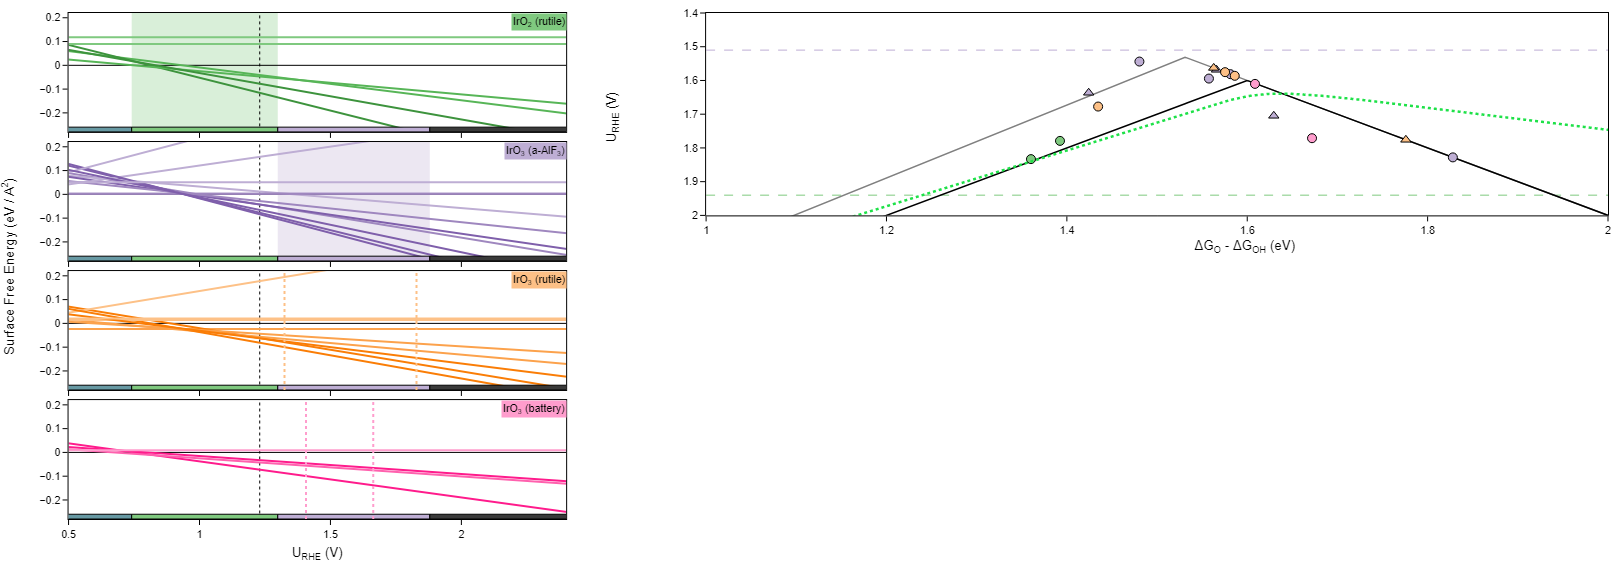

In [19]:
fig.show()

In [20]:
# fig.layout

In [21]:
# assert False

# Add minor ticks to plots

In [22]:
from plotting.my_plotly import add_minor_ticks, add_duplicate_axes
# from methods import add_duplicate_axes

shared_minor_axis = dict(ticklen=3, tickwidth=1, tickcolor="black")
# shared_minor_axis = dict(ticklen=10, tickwidth=1, tickcolor="red")

add_duplicate_axes(fig, axis_type="x",
    axis_data=dict(
        dtick=0.25,
        **shared_minor_axis),
    axis_num_list=axis_num_list)

add_duplicate_axes(fig, axis_type="y",
    axis_data=dict(
        dtick=0.05,
        **shared_minor_axis),
    axis_num_list=axis_num_list)


add_duplicate_axes(fig, axis_type="x",
    axis_data=dict(
        dtick=0.1,
        tick0=1.,
        **shared_minor_axis),
    axis_num_list=[2])

add_duplicate_axes(fig, axis_type="y",
    axis_data=dict(
        dtick=0.05,
        tick0=1.,
        **shared_minor_axis),
    axis_num_list=[2])

Writing pdf with ORCA
prepath: out_plot/combined__surf_pourb_oer


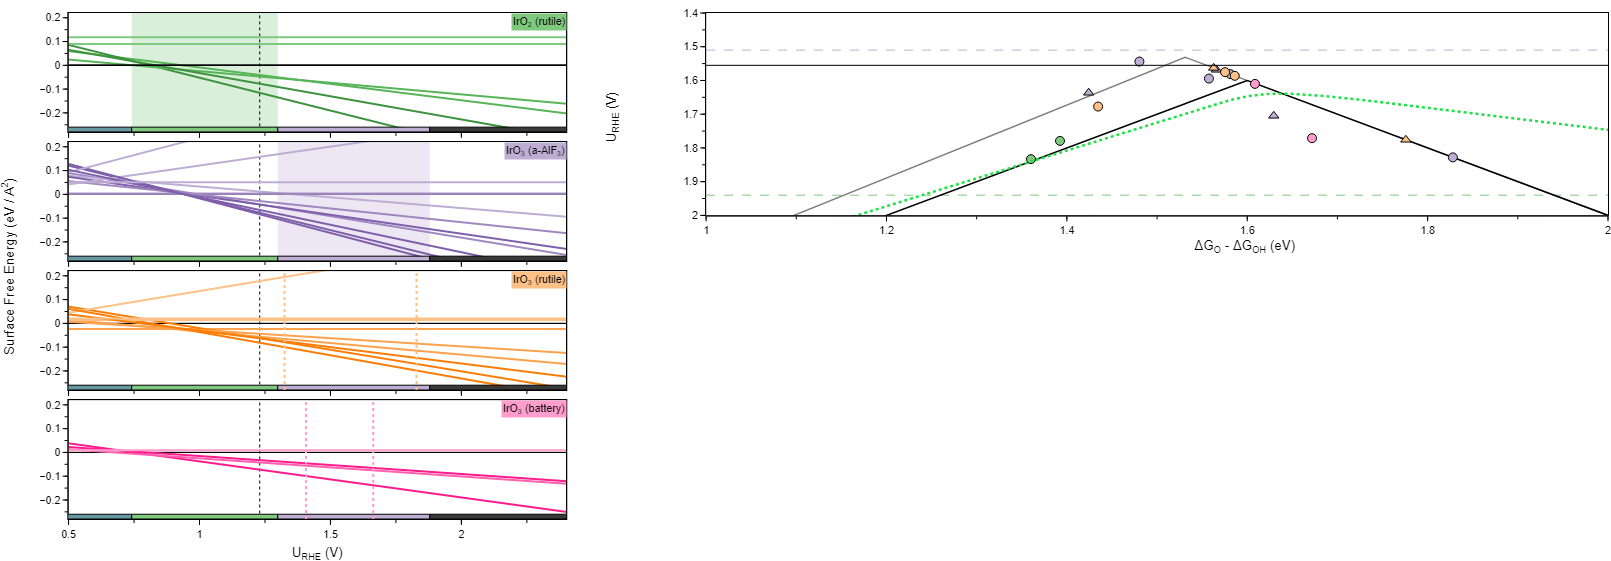

In [23]:
plot_name_i = "combined__surf_pourb_oer"
fig = my_plotly_plot(
    figure=fig,
    plot_name=plot_name_i,
    write_html=True,
    write_pdf=True,
    try_orca_write=True)

fig.show()

In [24]:
# import copy

# layout_tmp = copy.deepcopy(fig.layout)

# layout_tmp.annotations = None
# layout_tmp.shapes = None

# # layout_tmp

In [25]:
assert False

AssertionError: 

# Standard Surface Energy Bar Chart

In [ ]:
name_list = []
surf_e_list = []
color_list = []
label_list = []
for i_cnt, row_i in df_m.iterrows():
    
    # #########################################################################
    if row_i["coverage_type"] == "h_covered":
        label_i = "*OH"
    elif row_i["coverage_type"] == "o_covered":
        label_i = "*O"
    elif row_i["coverage_type"] == "bare":
        label_i = "*"
    elif row_i["coverage_type"] == "half_o_covered":
        label_i = "*O"
    else:
        print(row_i["coverage_type"])
        label_i = "TEMP"

    label_list.append(label_i)

    # #########################################################################
    surf_e_i = row_i["SurfaceEnergy"].std_surface_e_per_area
    surf_e_list.append(surf_e_i)

    # #########################################################################
#     name_i = row_i["bulk_system"] + " " + row_i["coverage_type"] + " " + row_i["facet"]
    name_i = row_i["bulk_system"] + " |" + label_i + "| " + row_i["facet"]

    name_list.append(name_i)

    # #########################################################################
    color_i = irox_surface_e_color_map.get(
        row_i["bulk_system"] + "_" + row_i["coverage_type"])
    color_list.append(color_i)


fig = go.Figure(
    data=[
        go.Bar(
            name='SF Zoo',
            x=name_list,
            y=surf_e_list,
            marker_color=color_list,
            text=label_list,
            textposition='auto',
            ),
        ],
    layout=go.Layout(
        height=600,
#         width=,
        )
    )

# Change the bar mode
fig.update_layout(barmode='group')

plot_name_i = "std_surf_e_bar_plot"
fig = my_plotly_plot(
    figure=fig,
    plot_name=plot_name_i,
    write_html=False,
    write_png=False,
    png_scale=6.0,
    write_pdf=False,
    write_svg=False,
    try_orca_write=False,
    )

# Image("out_plot/" + plot_name_i + ".png")

# fig.show()

In [ ]:
# </b>

# fig.layout


# 'yaxis2': {'anchor': 'x2',
#                'domain': [0.58, 0.9999999999999999],
#                'linecolor': 'black',
#                'mirror': True,
#                'range': [2.0, 1.4],
#                'showgrid': False,
#                'showline': True,
#                'tickcolor': 'black',
#                'tickfont': {'color': 'black', 'size': 10.666666666666666},
#                'ticks': 'outside',
#                'title': {'font': {'color': 'black'}, 'text': 'U<sub>RHE</sub> (V)'},

# fig.layout.yaxis2.title.text = "</b> U<sub>RHE</sub> (V) </b>"
# fig.layout.yaxis2.title.text = "U<sub>RHE</sub> (V)"
# fig.layout.yaxis2.title.text = "U<sub>RHE</sub> (V) <br>"
# fig.layout.yaxis2.title.text = "<br> <br> U<sub>RHE</sub> (V) <br> <br>"

# "U<sub>RHE</sub> (V)"

# fig

# fig.layout.yaxis2.title = None